In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/faces-data-new/images/lcelli.9.jpg
/kaggle/input/faces-data-new/images/9556273.13.jpg
/kaggle/input/faces-data-new/images/jgloma.15.jpg
/kaggle/input/faces-data-new/images/pmspry.5.jpg
/kaggle/input/faces-data-new/images/chr_exp.4.jpg
/kaggle/input/faces-data-new/images/vanta.15.jpg
/kaggle/input/faces-data-new/images/kdjone.16.jpg
/kaggle/input/faces-data-new/images/ldebna.17.jpg
/kaggle/input/faces-data-new/images/pacole.7.jpg
/kaggle/input/faces-data-new/images/jbgood.10.jpg
/kaggle/input/faces-data-new/images/kmbald.19.jpg
/kaggle/input/faces-data-new/images/saedwa.5.jpg
/kaggle/input/faces-data-new/images/asewil.14.jpg
/kaggle/input/faces-data-new/images/dakram.14.jpg
/kaggle/input/faces-data-new/images/robin.9.jpg
/kaggle/input/faces-data-new/images/smredh.3.jpg
/kaggle/input/faces-data-new/images/ptnich.15.jpg
/kaggle/input/faces-data-new/images/pgfost.16.jpg
/kaggle/input/faces-data-new/images/9540652.17.jpg
/kaggle/input/faces-data-new/images/wjsaic.5.jpg
/kaggle

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
GENERATE_RES = 3
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

SEED_SIZE = 100

DATA_PATH = "/kaggle/input/faces-data-new/"
WRITE_PATH = "/kaggle/working/"
EPOCHS = 50 #might be subject to change
BATCH_SIZE = 32 #might be subject to change
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")


Will generate 96px square images.


In [4]:
trainingBinaryPath = os.path.join(WRITE_PATH, f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {trainingBinaryPath}")

if not os.path.isfile(trainingBinaryPath):
    start = time.time()
    print("Loading training images...")
    trainingData = []
    facesPath = os.path.join(DATA_PATH, 'images')
    #we could just not use tqdm, but its going to show us a cool progress bar so we'll keep it in (i should use this personally too)
    for filename in tqdm(os.listdir(facesPath)):
        if(filename != "images"):
            path = os.path.join(facesPath, filename)
            image = Image.open(path).resize((GENERATE_SQUARE, GENERATE_SQUARE))
            trainingData.append(np.asarray(image))
    trainingData = np.reshape(trainingData, (-1, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS))
    trainingData = trainingData.astype(np.float32)
    trainingData = trainingData/127.5 - 1
    
    print("Saving training image binary...")
    np.save(trainingBinaryPath, trainingData)
    elapsed = time.time()-start
    print(f'Image preprocess time: {elapsed}')
else:
    print("Loading previous training pickle...")
    trainingData = np.load(trainingBinaryPath)
    

Looking for file: /kaggle/working/training_data_96_96.npy
Loading training images...


100%|██████████| 7865/7865 [01:16<00:00, 103.46it/s]


Saving training image binary...
Image preprocess time: 77.48849129676819


In [5]:
# Batch and shuffle the data
trainDataset = tf.data.Dataset.from_tensor_slices(trainingData) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def build_generator(seedSize, channels):
    model = Sequential() #allows us to create models layer by layer
    model.add(Dense(4*4*256, activation="relu", input_dim=seedSize))
    model.add(Reshape((4,4,256)))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=.8))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=.8))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=.8))
    model.add(Activation("relu"))
    
    if GENERATE_RES > 1:
        model.add(UpSampling2D(size=(GENERATE_RES, GENERATE_RES)))
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=.8))
        model.add(Activation("relu"))
        
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    return model    
        
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [7]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(WRITE_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

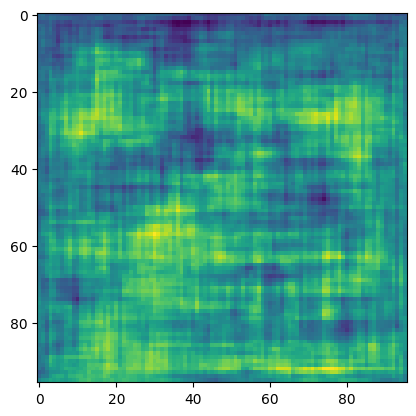

In [8]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [9]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5013317]], shape=(1, 1), dtype=float32)


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [12]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [13]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []
    i = 0
    for image_batch in dataset:
#         print(i)
#         i+=1
        t = train_step(image_batch)
        gen_loss_list.append(t[0])
        disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {(elapsed)}')

In [14]:
train(trainDataset, EPOCHS)

2023-10-19 18:18:46.372781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-19 18:19:29.188795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1, gen loss=2.8228414058685303,disc loss=0.9191171526908875, 48.287883281707764
1/1 [==============================] - 1s 1s/step
Epoch 2, gen loss=3.3097846508026123,disc loss=0.8346579670906067, 32.311702251434326
1/1 [==============================] - 0s 19ms/step
Epoch 3, gen loss=3.523094654083252,disc loss=0.6982549428939819, 32.87856912612915
1/1 [==============================] - 0s 20ms/step
Epoch 4, gen loss=3.3378114700317383,disc loss=0.8503382802009583, 32.4852819442749
1/1 [==============================] - 0s 20ms/step
Epoch 5, gen loss=3.130964517593384,disc loss=0.8320196270942688, 32.51275038719177
1/1 [==============================] - 0s 19ms/step
Epoch 6, gen loss=3.0269081592559814,disc loss=0.8575369119644165, 32.65513372421265
1/1 [==============================] - 0s 19ms/step
Epoch 7, gen loss=2.8720314502716064,disc loss=0.8569890856742859, 32.64891219139099
1/1 [==============================] - 0s 20ms/step
Epoch 8, gen loss=2.914846420288086,disc los

In [15]:
generator.save(os.path.join(WRITE_PATH,"face_generator.h5"))